# Fast Parallel Cheminformatics Workflows With Dask
> Acclerate you workflows with a couple of lines of code.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, dask, parallel]
- image: images/blog/dask_blog.png

In this post we'll take a look at how we can use [Dask](https://dask.org/) to parallelize and speed up Cheminformatics workflows with a couple of lines of code.  As an example we'll write a scritpt to calculate the properties from [Lipinski's Rule of 5](https://www.sciencedirect.com/science/article/abs/pii/S0169409X96004231).  Just for fun, we'll also add in the number of rotatable bonds.  We'll start by implementing a simple serial version, then modify that to run in parallel with Dask. 

### Single Processor Version

First we'll import the necessary Python libraries. 

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

Let's ensure that that Pandas dataframes are displayed with an appropriate number of decimal places.

In [2]:
pd.options.display.float_format = "{:,.2f}".format

Define a function to calculate the properties

In [3]:
def calc_r5(smiles):
    mol = Chem.MolFromSmiles(smiles)
    dummy = -9999.0
    res = [dummy, dummy, dummy, dummy, dummy]
    if mol:
        res = [Descriptors.MolWt(mol),Descriptors.MolLogP(mol),Descriptors.NumHDonors(mol),
               Descriptors.NumHAcceptors(mol),Descriptors.NumRotatableBonds(mol)]
    return res

Read a SMILES file into a Pandas dataframe

In [4]:
infile_name = "https://github.com/PatWalters/datafiles/blob/main/test.smi?raw=true"
df = pd.read_csv(infile_name,sep=" ",names=["SMILES","Name"])

Calculate the properties for the SMILES in the dataframe. 

In [5]:
df['R5'] = df.SMILES.apply(calc_r5)

Now we have all of the properties as a list in one column.  This isn't what we want. However, we can use this trick to create new columns from the list. 

In [6]:
df[["MW","LogP","HBD","HBA","Rot"]] = df.R5.to_list()

In [7]:
df

,SMILES,Name,R5,MW,LogP,HBD,HBA,Rot
0,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,675686,"[320.658, 3.877200000000003, 1, 2, 3]",320.66,3.88,1,2,3
1,Br.Cc1ccc(Sc2ccccc2N3CCNCC3)c(C)c1,1379657,"[379.3670000000002, 4.442140000000004, 1, 3, 3]",379.37,4.44,1,3,3
2,Br.CN(C)CCCC1(OCc2cc(ccc12)C#N)c3ccc(F)cc3,674732,"[405.31100000000004, 4.390880000000004, 0, 3, 5]",405.31,4.39,0,3,5
3,Br.CN1CCC[C@@H]1Cc2c[nH]c3ccc(CCS(=O)(=O)c4ccc...,674954,"[463.4410000000002, 4.398900000000004, 1, 3, 6]",463.44,4.40,1,3,6
4,Br.COc1ccc2CN(C)CC[C@@]34C=C[C@H](O)C[C@@H]3Oc...,443255,"[368.2710000000001, 2.4282000000000004, 1, 4, 1]",368.27,2.43,1,4,1
...,...,...,...,...,...,...,...,...
95,CC(C)CC(N(C)C)C1(CCC1)c2ccc(Cl)cc2,358192,"[279.85499999999996, 4.738000000000005, 0, 1, 5]",279.85,4.74,0,1,5
96,CC(C)CC1(CC=C)C(=O)NC(=O)NC1=O,2524,"[224.26, 0.9609999999999999, 2, 3, 4]",224.26,0.96,2,3,4
97,CC(C)Cc1ccc(cc1)C(C)C(=O)O,11674,"[206.28499999999997, 3.073200000000001, 1, 1, 4]",206.28,3.07,1,1,4
98,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2\C(=C\C=C/3\C[C...,125294,"[384.6480000000003, 7.619000000000009, 1, 1, 6]",384.65,7.62,1,1,6


At this point, we no longer need the R5 column, so we can get rid of it. 

In [8]:
df.drop("R5",axis=1,inplace=True)

Finally, we can write the results to a csv file.  

In [9]:
df.to_csv("props.csv",index=False)

### Parallel Version

In order to parallelize this calculation with Dask, we need an additional import.

In [10]:
import dask.dataframe as dd

We also need to convert the Pandas dataframe to a Dask dataframe. In the constructor for the Dask dataframe, we specify an argument "npartitions", that defines the number of chunks to divide the dataframe into for the calculation.  This seems to be most efficeint when we set "npartitions" to the number of processor cores. 

In [11]:
num_cores = 8
ddf = dd.from_pandas(df,npartitions=num_cores)

Parallelization with Dask requires a function that accepts a dataframe as input. We can define a function that uses the "apply" from the serial version above.  

In [12]:
def df_r5(df_in):
    return df_in.SMILES.apply(calc_r5)

Now we can parallelize our workflow with a single line of code.

In [13]:
df["R5"] = ddf.map_partitions(df_r5,meta='float').compute(scheduler='processes')

We can use the same method we described above to split the "R5" column into multiple columns. 

In [14]:
df[["MW","LogP","HBD","HBA","Rot"]] = df.R5.to_list()
df.drop("R5",axis=1,inplace=True)

### Benchmarking

Let's take a look at how much of a speedup we can get by using Dask.  To do this, we'll take a look at how long it takes to calculate the five properties above for 1 million molecules from the ZINC database.  The input file is large so I didn't include it in this post.  Here's the code I used to perform the benchmark. 

In [18]:
import time

df = pd.read_csv("zinc_1M.smi",sep=" ",names=["SMILES","Name"])
runtime_res = []
for num_cores in range(1,9):
    ddf = dd.from_pandas(df,npartitions=num_cores)
    start = time.time()
    df["R5"] = ddf.map_partitions(df_r5,meta='float').compute(scheduler='processes')
    elapsed = time.time()-start
    df[["MW","LogP","HBD","HBA","Rot"]] = df.R5.to_list()
    df.drop("R5",axis=1,inplace=True)
    df.to_csv("props.csv",index=False,float_format="%0.2f")
    print(f"{len(df)} molecules processed in {elapsed:0.2f} sec on {num_cores} cores")
    runtime_res.append([elapsed,num_cores])

1000000 molecules processed in 714.70 sec on 1 cores
1000000 molecules processed in 378.56 sec on 2 cores
1000000 molecules processed in 272.38 sec on 3 cores
1000000 molecules processed in 211.11 sec on 4 cores
1000000 molecules processed in 177.00 sec on 5 cores
1000000 molecules processed in 158.07 sec on 6 cores
1000000 molecules processed in 146.98 sec on 7 cores
1000000 molecules processed in 142.83 sec on 8 cores


Make a dataframe so that we can view the results.  We'll add a column with the runtime ratio for n cores to 1 core. 

In [23]:
runtime_df = pd.DataFrame(runtime_res,columns=["Runtime","Cores"])
one_core_time = runtime_df.Runtime.values[0]
runtime_df['Ratio'] = one_core_time/runtime_df.Runtime

View the results. 5x speed-up with 8 cores, not too bad for one line of code. 

In [24]:
runtime_df

,Runtime,Cores,Ratio
0,714.70,1,1.00
1,378.56,2,1.89
2,272.38,3,2.62
3,211.11,4,3.39
4,177.00,5,4.04
5,158.07,6,4.52
6,146.98,7,4.86
7,142.83,8,5.00


Plot the results.

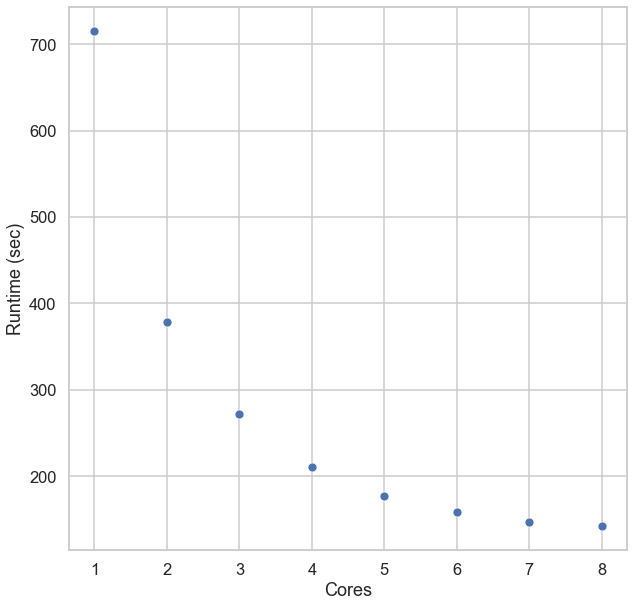

In [25]:
import seaborn as sns

sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

ax = sns.scatterplot(x="Cores",y="Runtime",data=runtime_df)
ax.set(ylabel="Runtime (sec)");

### Caveats

The method described here is only going to work for datasets that will fit into memory.  You can use this method to process millions of molecules, but it won't work for billions.  Dask has other methods for dealing with data that won't fit into memory.  We'll save that discussion for another day. 

### Acknowledgments

I'd like to thank Yutong Zhao, Greg Landrum, Peter St. John, and Maciek Wójcikowski for valuable advice.